In [1]:
my_name = "WeiHung Hsu"
my_teammate = "Maja garbulinska" 
my_team_name = "papwomen" # Your team name on the submission server

print("I'm %s. I worked with %s. I'm on team %s" % (my_name, my_teammate, my_team_name))

I'm WeiHung Hsu. I worked with Maja garbulinska. I'm on team papwomen


# Section 1: Downloading the dataset

You can download the dataset from <http://www.cs.uoi.gr/~marina/sipakmed.html>

In [2]:
import os
# Root of data. Change this to match your directory structure. 
# datadir should contain train/ val/ and test/

data_dir = "full_5_split"

# Section 2: Training a Model

Now, we'll train a model. This code was adapted from <https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html>

You are free to delete this code entirely and start from scratch, or modify it in whatever way you choose

# Finetune Methods
1. Data augmentation (Random Rotation)
2. Add Drop out layer
3. Learning rate scheduler (Annealing/scheduling)
4. Different optimizer
5. Train last linear layer

https://medium.com/udacity-pytorch-challengers/ideas-on-how-to-fine-tune-a-pre-trained-model-in-pytorch-184c47185a20

## Dependencies

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm import tqdm
# import optimizer library
from torch.optim.lr_scheduler import StepLR

import os
import copy

# display image
!pip install -U image
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

fastai 1.0.58 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: image in /home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (1.5.27)
Requirement not upgraded as not directly required: pillow in /home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from image) (5.2.0)
Requirement not upgraded as not directly required: django in /home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from image) (3.0)
Requirement not upgraded as not directly required: pytz in /home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from django->image) (2018.4)
Requirement not upgraded as not directly required: asgiref~=3.2 in /home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from django->image) (3.2.3)
Requirement not upgraded as not directly required: sqlp

## Initialize an Empty Model

First, we need to initialize an empty model, that will input an image, and output a classification. Each model is a little different, so we'll make a helper function that takes in an architecture name, and outputs a model. This is only meant as a guideline, and you can try using different models! `torchvision.models` has other common architectures, and variations on these (like ResNet-50 and ResNet-101), so you may want to try those out.

We also add a `resume_from` argument to specify model weights to load, In case you save a model and want to use it again.

In [4]:
def initialize_model(model_name, num_classes, resume_from = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224
    
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224  
        
    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224    

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

## Data Loading

With the input size from the model, we can now load the dataset

In [5]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    
    # add random rotation to data augmentation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    class_names = image_datasets['train'].classes
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict, class_names

## Training
Next, let's make a helper function that trains the given model

In [6]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # scheduler step
#             scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc

## Optimizer & Loss
We need a loss function, and an optimization function to use to try to reduce that loss.

In [7]:
def make_optimizer(model):
    # Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    # Use SGD
    #optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    optimizer = optim.Adam(params_to_update, lr=0.001)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

## Inputs

Here, we set up some of the various parameters that we can change to run the code. You can add change the values given here, or add new ones! This is just a template.

Our data is conveniently set up to follow the expected format of the  `ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset class, rather than writing our own custom dataset.

The ``model_name`` input is the name of the model you wish to use. We've provided starter code that initializes these models using provided models in TorchVision (a PyTorch library)

The code as is supports the following values: [resnet, alexnet, vgg, squeezenet, densenet]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, 100 here, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs (passes through the dataset) we want to run.


In [34]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "resnet50"

# Number of classes in the dataset
# Superficial-Intermediate, Parabasal, Koilocytotic, Dysketarotic, Metaplastic
num_classes = 5

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 50

### IO
# Path to a model file to use to start weights at
resume_from = None

# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# Save weights for all epochs, not just the best one
save_all_epochs = True

# data dir
data_dir = "cropped_5_split"

## Tying it all together - Training

In [35]:
# Initialize the model
model, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from = resume_from)
# get dataloaders
dataloaders, class_name = get_dataloaders(input_size, batch_size, shuffle_datasets)
# loss function
criterion = get_loss()

In [36]:
# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
# scheduler for optimizing
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [37]:
# Train the model!
trained_model, train_losses, train_acc, val_losses, val_acc = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 1.1844 Acc: 0.5913


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.8876 Acc: 0.6948

Epoch 1/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.9668 Acc: 0.6555


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.6874 Acc: 0.7370

Epoch 2/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.8459 Acc: 0.6932


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.7452 Acc: 0.7469

Epoch 3/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.8057 Acc: 0.7149


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.6483 Acc: 0.7618

Epoch 4/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.8171 Acc: 0.7071


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.7649 Acc: 0.7221

Epoch 5/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.7695 Acc: 0.7272


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.6450 Acc: 0.7543

Epoch 6/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.7250 Acc: 0.7334


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.7631 Acc: 0.7419

Epoch 7/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.6594 Acc: 0.7556


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.5391 Acc: 0.7990

Epoch 8/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.6498 Acc: 0.7671


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.5548 Acc: 0.7816

Epoch 9/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.5921 Acc: 0.7905


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.5152 Acc: 0.7965

Epoch 10/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.5788 Acc: 0.7896


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.7270 Acc: 0.8015

Epoch 11/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.5539 Acc: 0.8075


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.5329 Acc: 0.8213

Epoch 12/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.5271 Acc: 0.8048


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.5910 Acc: 0.7990

Epoch 13/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.4852 Acc: 0.8245


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.3568 Acc: 0.8511

Epoch 14/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.4506 Acc: 0.8434


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.3497 Acc: 0.8561

Epoch 15/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.4537 Acc: 0.8499


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.4806 Acc: 0.8412

Epoch 16/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.4498 Acc: 0.8468


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.4173 Acc: 0.8660

Epoch 17/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.4128 Acc: 0.8588


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.3537 Acc: 0.8734

Epoch 18/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.4005 Acc: 0.8607


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2972 Acc: 0.8933

Epoch 19/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3553 Acc: 0.8715


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.3589 Acc: 0.8635

Epoch 20/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3928 Acc: 0.8650


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2867 Acc: 0.9007

Epoch 21/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3603 Acc: 0.8770


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.3050 Acc: 0.8834

Epoch 22/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3592 Acc: 0.8755


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.3357 Acc: 0.8759

Epoch 23/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3311 Acc: 0.8845


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2916 Acc: 0.9057

Epoch 24/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3199 Acc: 0.8919


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.4127 Acc: 0.8635

Epoch 25/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3143 Acc: 0.8876


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2685 Acc: 0.8908

Epoch 26/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3095 Acc: 0.8934


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.3462 Acc: 0.8908

Epoch 27/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3065 Acc: 0.8876


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2748 Acc: 0.8809

Epoch 28/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.3108 Acc: 0.8885


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2826 Acc: 0.8958

Epoch 29/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2720 Acc: 0.9052


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2386 Acc: 0.9256

Epoch 30/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2688 Acc: 0.9039


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2828 Acc: 0.9032

Epoch 31/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2648 Acc: 0.9070


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2540 Acc: 0.9305

Epoch 32/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2615 Acc: 0.9039


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2191 Acc: 0.9206

Epoch 33/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2638 Acc: 0.9049


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2219 Acc: 0.9280

Epoch 34/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2564 Acc: 0.9092


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2561 Acc: 0.9132

Epoch 35/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2398 Acc: 0.9138


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2753 Acc: 0.9082

Epoch 36/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2298 Acc: 0.9160


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2317 Acc: 0.9280

Epoch 37/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2358 Acc: 0.9175


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2230 Acc: 0.9305

Epoch 38/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2289 Acc: 0.9181


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2727 Acc: 0.9082

Epoch 39/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2162 Acc: 0.9203


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2454 Acc: 0.9107

Epoch 40/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2046 Acc: 0.9302


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2869 Acc: 0.9132

Epoch 41/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2416 Acc: 0.9184


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.1985 Acc: 0.9280

Epoch 42/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2179 Acc: 0.9249


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.3958 Acc: 0.9206

Epoch 43/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2392 Acc: 0.9166


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.4164 Acc: 0.8883

Epoch 44/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2143 Acc: 0.9237


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2132 Acc: 0.9256

Epoch 45/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.1922 Acc: 0.9280


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2277 Acc: 0.9206

Epoch 46/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.1949 Acc: 0.9293


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.3233 Acc: 0.9057

Epoch 47/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.2073 Acc: 0.9293


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2377 Acc: 0.9256

Epoch 48/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.1810 Acc: 0.9391


  0%|          | 0/203 [00:00<?, ?it/s]

val Loss: 0.2917 Acc: 0.9181

Epoch 49/49
----------


  0%|          | 0/26 [00:00<?, ?it/s]

train Loss: 0.1848 Acc: 0.9364


100%|██████████| 26/26 [00:00<00:00, 31.91it/s]

val Loss: 0.1765 Acc: 0.9330

Training complete in 11m 11s
Best val Acc: 0.933002


In [38]:
# save pretrained weights
torch.save(trained_model.state_dict(), "weights/cropped_5/resnet50")

# Section 3: Plot losses and accuracy



In [14]:
# x label for training 50 to 100 epoch
x = np.arange(0,50,1)

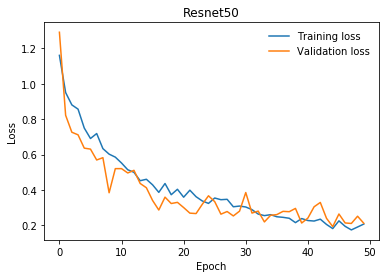

In [16]:
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("Resnet50")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

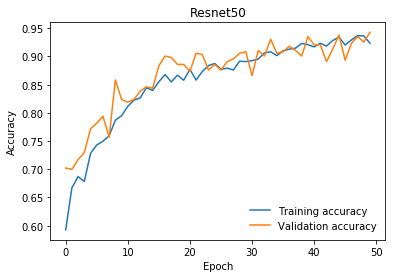

In [17]:
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.title("Resnet50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Section 4: Inference

Now that we've trained a model, we would like to evaluate its performance (on the validation data), and use it for inference (on the test data). We're going to perform top-5 inference - that is, our model will get to output 5 guesses for a given image


In [39]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=5, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels


In [40]:
# set data dir to full image
# data_dir = "full_image"
# set data dir to crop image
data_dir = "cropped_5_split"
# get full image data as testing data
dataloaders, class_name = get_dataloaders(input_size, batch_size, True)

In [41]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 5)

# Get predictions for the test set
epoch_loss, top1_acc, top5_acc, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 5)

100%|██████████| 26/26 [00:00<00:00, 32.62it/s]


In [42]:
top1_acc

0.941320293398533

# Section 5: Confusion Matrix

In [43]:
# data directory of cropped images
data_dir = "images"
class_names = ['im_Dyskeratotic_CROPPED',
            'im_Koilocytotic_CROPPED',
            'im_Metaplastic_CROPPED',
            'im_Parabasal_CROPPED',
            'im_Superficial-Intermediate_CROPPED']

In [44]:
# initialize confusion matrix
confusion_matrix = {x: [0,0,0,0,0] for x in class_name}

In [45]:
# load cropped images 
input_size = 224
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_dir,
                         transforms.Compose([
                             transforms.Resize(input_size),
                             transforms.CenterCrop(input_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])),
    batch_size = 1,
    shuffle = False)

In [46]:
# move model to GPU
model = model.to(device)
running_top1_correct = 0
# generate confusion matrix on test data
loader = dataloaders['test']
# generate confusion matrix on all cropped data
# loader = train_loader
for inputs, labels in tqdm(loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # predict output
    outputs = model(inputs)
    _, preds = torch.topk(outputs, k=1, dim=1)
    # generate confusion matrix
    for i in range(len(labels)):
        original_label = int(labels[i])
        confusion_matrix[class_names[original_label]][int(preds[i])] += 1
        
    running_top1_correct += torch.sum(preds[:, 0] == labels.data)

epoch_top1_acc = float(running_top1_correct.double() / len(loader.dataset))

100%|██████████| 26/26 [00:00<00:00, 31.62it/s]


In [47]:
print(confusion_matrix)
# total accuracy
print(epoch_top1_acc)

{'im_Dyskeratotic_CROPPED': [78, 3, 1, 0, 0], 'im_Koilocytotic_CROPPED': [1, 78, 3, 0, 1], 'im_Metaplastic_CROPPED': [1, 3, 70, 4, 2], 'im_Parabasal_CROPPED': [0, 0, 0, 80, 0], 'im_Superficial-Intermediate_CROPPED': [0, 3, 3, 0, 78]}
0.9388753056234719


In [48]:
percentage = {x: [y /sum(confusion_matrix[x]) for y in confusion_matrix[x]] for x in confusion_matrix.keys()}
percentage

{'im_Dyskeratotic_CROPPED': [0.9512195121951219,
  0.036585365853658534,
  0.012195121951219513,
  0.0,
  0.0],
 'im_Koilocytotic_CROPPED': [0.012048192771084338,
  0.9397590361445783,
  0.03614457831325301,
  0.0,
  0.012048192771084338],
 'im_Metaplastic_CROPPED': [0.0125, 0.0375, 0.875, 0.05, 0.025],
 'im_Parabasal_CROPPED': [0.0, 0.0, 0.0, 1.0, 0.0],
 'im_Superficial-Intermediate_CROPPED': [0.0,
  0.03571428571428571,
  0.03571428571428571,
  0.0,
  0.9285714285714286]}

# Section 6: Test single image

In [12]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

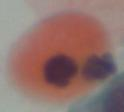

In [13]:
img0 = PIL.Image.open('images_cropped/train/im_Dyskeratotic_CROPPED/021_01.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [21]:
# return the top 5 predictions and its probabilities
def test_single_image(image):
    input_size = 224
    center_crop = transforms.Compose([
         transforms.Resize((input_size)),
         transforms.CenterCrop(input_size),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    im = center_crop(image)
    out = model(im.unsqueeze(0)).squeeze()
    # get the probability and category of top5 prediction
    prob, categories = out.topk(5)
    # convert the probability to softmax
    sm = torch.nn.Softmax()
    probabilities = sm(prob) 
    for i in range(len(categories)):
        print(class_name[int(categories[i])] + ": " + str(float(probabilities[i])))

In [15]:
test_single_image(img0)

im_Koilocytotic_CROPPED: 0.817899763584137
im_Dyskeratotic_CROPPED: 0.13483375310897827
im_Superficial-Intermediate_CROPPED: 0.047263938933610916
im_Metaplastic_CROPPED: 1.5374467920992174e-06
im_Parabasal_CROPPED: 9.478748097535572e-07


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Section 7: Test multiple images

In [16]:
class_name

['im_Dyskeratotic_CROPPED',
 'im_Koilocytotic_CROPPED',
 'im_Metaplastic_CROPPED',
 'im_Parabasal_CROPPED',
 'im_Superficial-Intermediate_CROPPED']

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.figure(figsize=(20,10))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [18]:
# get the next batch of inputs
inputs, classes = next(iter(dataloaders['train']))

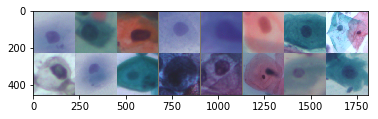

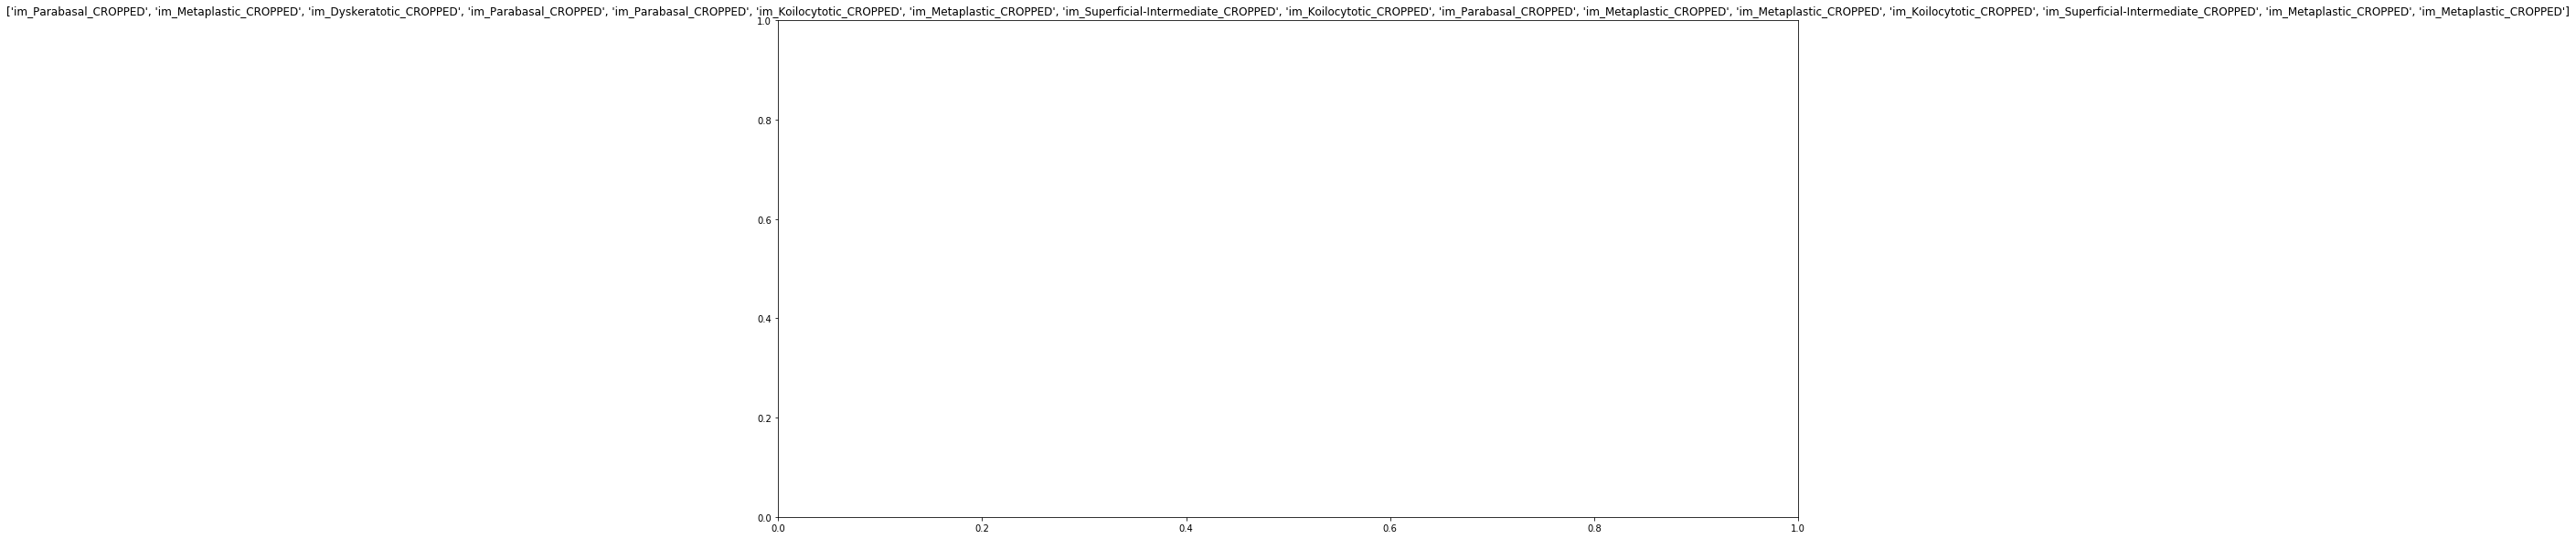

In [19]:
# visualize next batch of inputs
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_name[x] for x in classes])

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    # impacts the autograd engine and deactivate it
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # iterate this batch
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, label: {}'.format(class_name[preds[j]], class_name[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

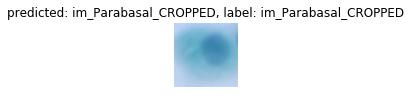

<Figure size 1440x720 with 0 Axes>

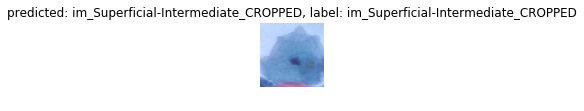

<Figure size 1440x720 with 0 Axes>

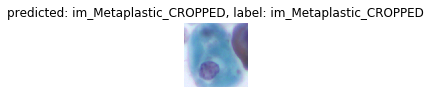

<Figure size 1440x720 with 0 Axes>

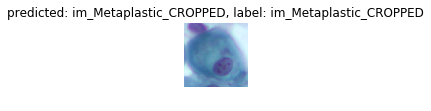

<Figure size 1440x720 with 0 Axes>

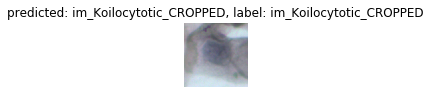

<Figure size 1440x720 with 0 Axes>

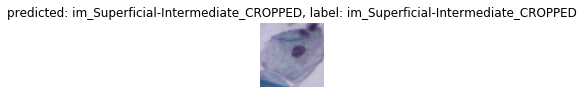

<Figure size 1440x720 with 0 Axes>

In [27]:
visualize_model(model)

# Section 8: Test full image

With the pre-trained classifier, we will try to use it on to a full image. Because we don't have location labels for cells on the full image. We will try slicing the image into patches. Then for each class, we apply the classifier to detect if there is a abnormal cell. 

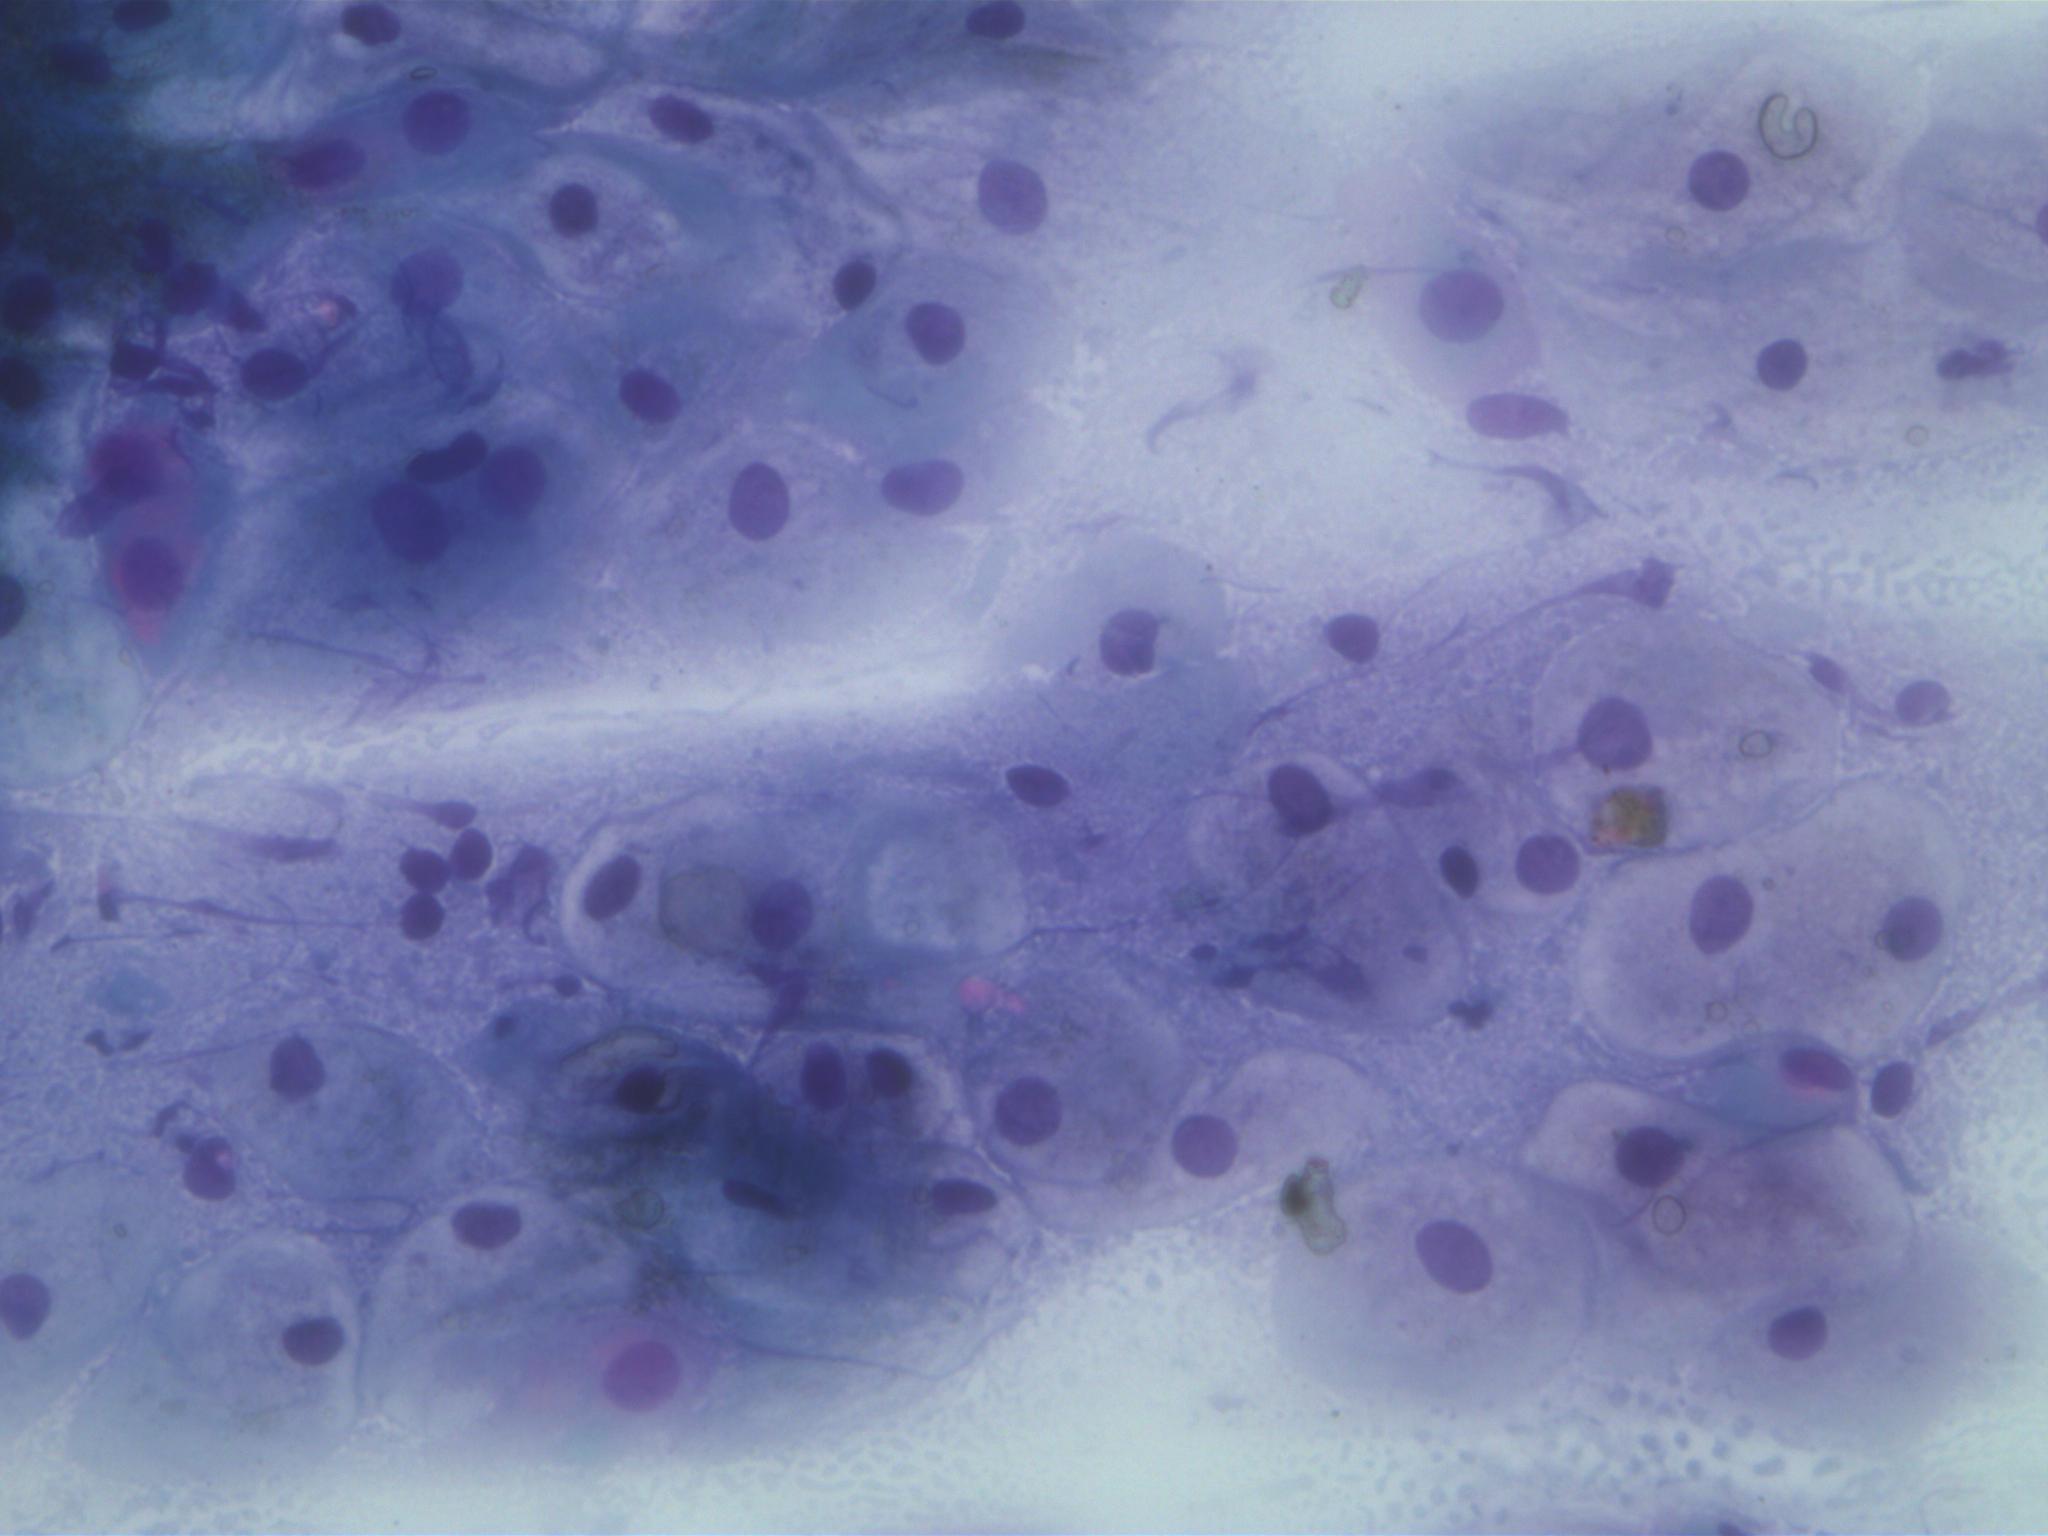

In [21]:
# view full image
img0 = PIL.Image.open('full_image/train/im_Parabasal/002.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [22]:
# shape of full image
img_numpy.shape

(1536, 2048, 3)

torch.Size([3, 256, 256])


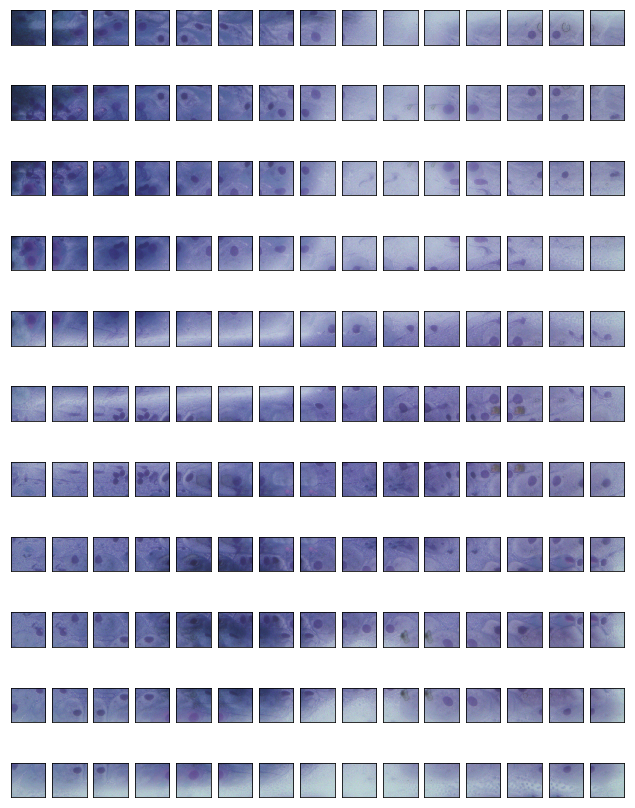

In [23]:
# patches = x.unfold(dim, size, stride).unfold(dim, size, stride).unfold(dim, size, stride)
transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(PIL.Image.open('full_image/train/im_Parabasal/002.bmp'))

#torch.Tensor.unfold(dimension, size, step)
#slices the images into 8*8 size patches
size = 256
stride = 128
# first color channel dimension, include all three
# width and height dimension find the common factor of the two for size and stride
patches = img_t.data.unfold(0, 3, 3).unfold(1, size, stride).unfold(2, size, stride)
print(patches[0][0][0].shape)

def visualize(patches):
    """Imshow for Tensor."""   
    # number of slices on height
    slice_h = patches.shape[1]
    slice_w = patches.shape[2]
    fig = plt.figure(figsize=(slice_h, slice_w))
    for i in range(patches.shape[1]):
        for j in range(patches.shape[2]):
            inp = transp(patches[0][i][j])
            inp = np.array(inp)
            ax = fig.add_subplot(slice_h, slice_w, ((i*slice_w)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(patches)

In [38]:
patches.shape

torch.Size([1, 6, 8, 3, 256, 256])

In [ ]:
input_size = 224
for i in range(patches.shape[1]):
    for j in range(patches.shape[2]):
        normalize = transforms.Compose([
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # print image 
        
        # resize tensor to model input size
        x = F.interpolate(patches[0][i][j], size=224) 
        im = normalize(x)
        out = model(im.unsqueeze(0)).squeeze()
        # get the probability and category of top5 prediction
        prob, categories = out.topk(5)
        # convert the probability to softmax
        sm = torch.nn.Softmax()
        probabilities = sm(prob) 
        
        print(class_name[int(categories[0])] + ": " + str(float(probabilities[0])))
        inp = transp(patches[0][i][j])
        inp = np.array(inp)
        showarray(inp)

In [ ]:
# problem with this approach is different kinds of cells have different cell sizes. Each patch has the fixed size. 